# Predicting Wind Turbine Power Production using SCADA Data

# The columns descriptions:

- Date/Time : readings for 10 minutes intervals
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- TheoreticalPowerCurve (kW): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [209]:
data = pd.read_csv("https://raw.githubusercontent.com/amrhkm/wind-turbine-power-prediction/master/T1.csv?token=GHSAT0AAAAAAB5FQJBVQNMXWA4CHEHFPSRYZCPIHBA")
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)   
0  01 01 2018 00:00           380.047791          5.311336  \
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286

# Data Prep

## Renaming Columns

In [210]:
data = data.rename(columns={
    'LV ActivePower (kW)': 'power_kw',
    'Wind Speed (m/s)': 'wind_speed_ms',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power_kw',
    'Wind Direction (°)': 'wind_direction_deg'
})

data.head()

Date/Time    power_kw  wind_speed_ms  theoretical_power_kw   
0  01 01 2018 00:00  380.047791       5.311336            416.328908  \
1  01 01 2018 00:10  453.769196       5.672167            519.917511   
2  01 01 2018 00:20  306.376587       5.216037            390.900016   
3  01 01 2018 00:30  419.645905       5.659674            516.127569   
4  01 01 2018 00:40  380.650696       5.577941            491.702972   

   wind_direction_deg  
0          259.994904  
1          268.641113  
2          272.564789  
3          271.258087  
4          265.674286

## Data Discovery

In [211]:
data.columns

Index(['Date/Time', 'power_kw', 'wind_speed_ms', 'theoretical_power_kw',
       'wind_direction_deg'],
      dtype='object')

In [212]:
data.shape

(50530, 5)

In [213]:
data.describe()

power_kw  wind_speed_ms  theoretical_power_kw  wind_direction_deg
count  50530.000000   50530.000000          50530.000000        50530.000000
mean    1307.684332       7.557952           1492.175463          123.687559
std     1312.459242       4.227166           1368.018238           93.443736
min       -2.471405       0.000000              0.000000            0.000000
25%       50.677890       4.201395            161.328167           49.315437
50%      825.838074       7.104594           1063.776283           73.712978
75%     2482.507568      10.300020           2964.972462          201.696720
max     3618.732910      25.206011           3600.000000          359.997589

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date/Time             50530 non-null  object 
 1   power_kw              50530 non-null  float64
 2   wind_speed_ms         50530 non-null  float64
 3   theoretical_power_kw  50530 non-null  float64
 4   wind_direction_deg    50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [215]:
data.isnull().sum()

Date/Time               0
power_kw                0
wind_speed_ms           0
theoretical_power_kw    0
wind_direction_deg      0
dtype: int64

No null values

In [216]:
df = data.copy() # to be manipulated

## Checking for outliers

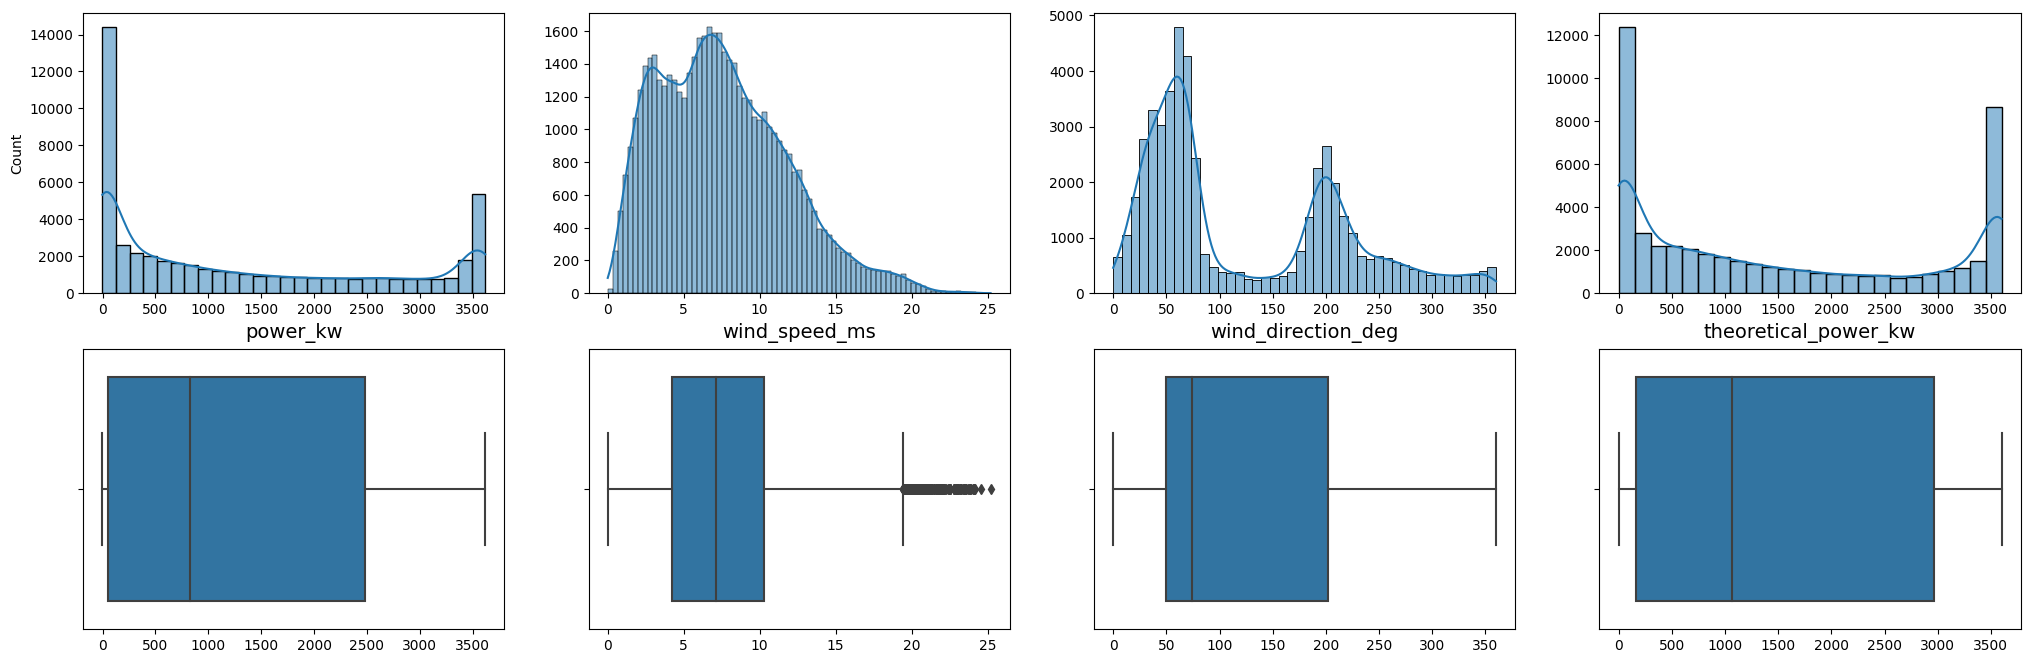

In [217]:
columns = ['power_kw', 'wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw']


fig, axs = plt.subplots(nrows=2, ncols=len(columns), figsize=(25, 8))

# Plot distplot for each variable
for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=axs[0, i])
    axs[0, i].set_xlabel(col, size = 14)
    sns.boxplot(data=df, x=col, ax=axs[1, i], orient='h')
    axs[1, i].set_xlabel('')

for i in range(1, len(columns)):
    axs[0, i].set_ylabel('')
    axs[1, i].set_ylabel('')

plt.show()

we could see that only the column 'Wind_speed_ms' has an outlier

### Dealing with outliers

In [218]:
# checking for exact amout of outlier present
def detect_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# to remove outliers using the IQR method
def remove_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [219]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape[0])
  

Outliers for power_kw : 0
Outliers for wind_speed_ms : 423
Outliers for theoretical_power_kw : 0
Outliers for wind_direction_deg : 0


the column Wind Speed has 423 outlier

In [220]:
outliers_wind_speed = detect_outliers_IQR(df, 'wind_speed_ms')
outliers_wind_speed[['wind_speed_ms','power_kw']].describe()


wind_speed_ms     power_kw
count     423.000000   423.000000
mean       20.665708  3571.622091
std         1.158747    57.208407
min        19.449539  3460.064941
25%        19.808920  3599.670532
50%        20.311859  3601.531006
75%        21.094854  3602.329468
max        25.206011  3603.895996

- The lowest wind speed within the outlier wind speed is 19.449539184570 m/s
- The lowest power produced by the outlier wind speed is 3460.064941 kW

### Replacing the outlier values for wind speed

#### Instead of removing all the outliers for the wind speed, any value larger than the minimum outlier value will be replace by 19 as their wind speed

In [221]:
df['wind_speed_ms'] = np.where( df['wind_speed_ms'] >= 19.4495391845703, 19, 1 * df['wind_speed_ms'] )

In [222]:
# checking if wind speed value higher than minimum outlier value still exist

df[df['wind_speed_ms'] >= 19.4495391845703]['wind_speed_ms'].count()

0

wind speed outliers removed

In [223]:
df[df['wind_speed_ms'] ==  19]['wind_speed_ms'].count()

423

#### 432 outlier wind speed was replaced by 19 m/s

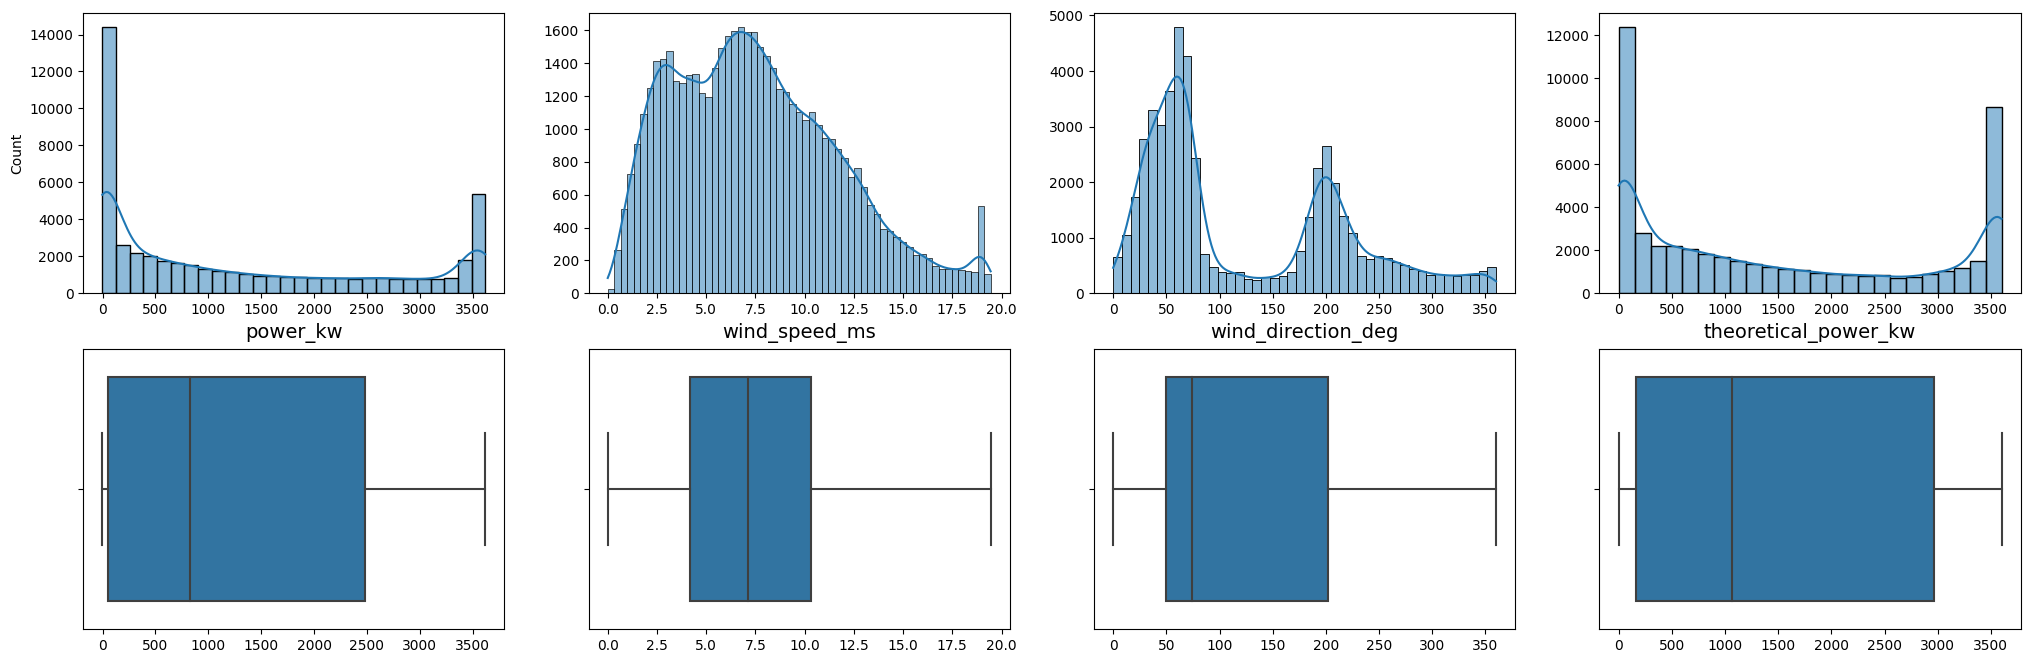

In [224]:
columns = ['power_kw', 'wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw']


fig, axs = plt.subplots(nrows=2, ncols=len(columns), figsize=(25, 8))

# Plot distplot for each variable
for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=axs[0, i])
    axs[0, i].set_xlabel(col, size = 14)
    sns.boxplot(data=df, x=col, ax=axs[1, i], orient='h')
    axs[1, i].set_xlabel('')

for i in range(1, len(columns)):
    axs[0, i].set_ylabel('')
    axs[1, i].set_ylabel('')

plt.show()

Wind Speed outlier no longer present

In [225]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape[0])

Outliers for power_kw : 0
Outliers for wind_speed_ms : 0
Outliers for theoretical_power_kw : 0
Outliers for wind_direction_deg : 0


## Dealing with date and time

In [226]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format= "%d %m %Y %H:%M")

df['year'] = df['Date/Time'].dt.year
df['month'] = df['Date/Time'].dt.month
df['day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour

df.head()

Date/Time    power_kw  wind_speed_ms  theoretical_power_kw   
0 2018-01-01 00:00:00  380.047791       5.311336            416.328908  \
1 2018-01-01 00:10:00  453.769196       5.672167            519.917511   
2 2018-01-01 00:20:00  306.376587       5.216037            390.900016   
3 2018-01-01 00:30:00  419.645905       5.659674            516.127569   
4 2018-01-01 00:40:00  380.650696       5.577941            491.702972   

   wind_direction_deg  year  month  day  hour  
0          259.994904  2018      1    1     0  
1          268.641113  2018      1    1     0  
2          272.564789  2018      1    1     0  
3          271.258087  2018      1    1     0  
4          265.674286  2018      1    1     0

In [227]:
df = df.drop(['Date/Time'], axis=1)

In [228]:
df

power_kw  wind_speed_ms  theoretical_power_kw  wind_direction_deg   
0       380.047791       5.311336            416.328908          259.994904  \
1       453.769196       5.672167            519.917511          268.641113   
2       306.376587       5.216037            390.900016          272.564789   
3       419.645905       5.659674            516.127569          271.258087   
4       380.650696       5.577941            491.702972          265.674286   
...            ...            ...                   ...                 ...   
50525  2963.980957      11.404030           3397.190793           80.502724   
50526  1684.353027       7.332648           1173.055771           84.062599   
50527  2201.106934       8.435358           1788.284755           84.742500   
50528  2515.694092       9.421366           2418.382503           84.297913   
50529  2820.466064       9.979332           2779.184096           82.274620   

       year  month  day  hour  
0      2018      1    1     0  
1      2018      1    1     0  
2      2018      1    1     0  
3      2018      1    1     0  
4      2018      1    1     0  
...     ...    ...  ...   ...  
50525  2018     12   31    23  
50526  2018     12   31    23  
50527  2018     12   31    23  
50528  2018     12   31    23  
50529  2018     12   31    23  

[50530 rows x 8 columns]

In [229]:
# import os

# directory_path = r'C:\Users\hamir\Desktop\Wind Turbine'

# file_name = os.path.join(directory_path, 'df.csv')

# df.to_csv(file_name, index=False)


# EDA

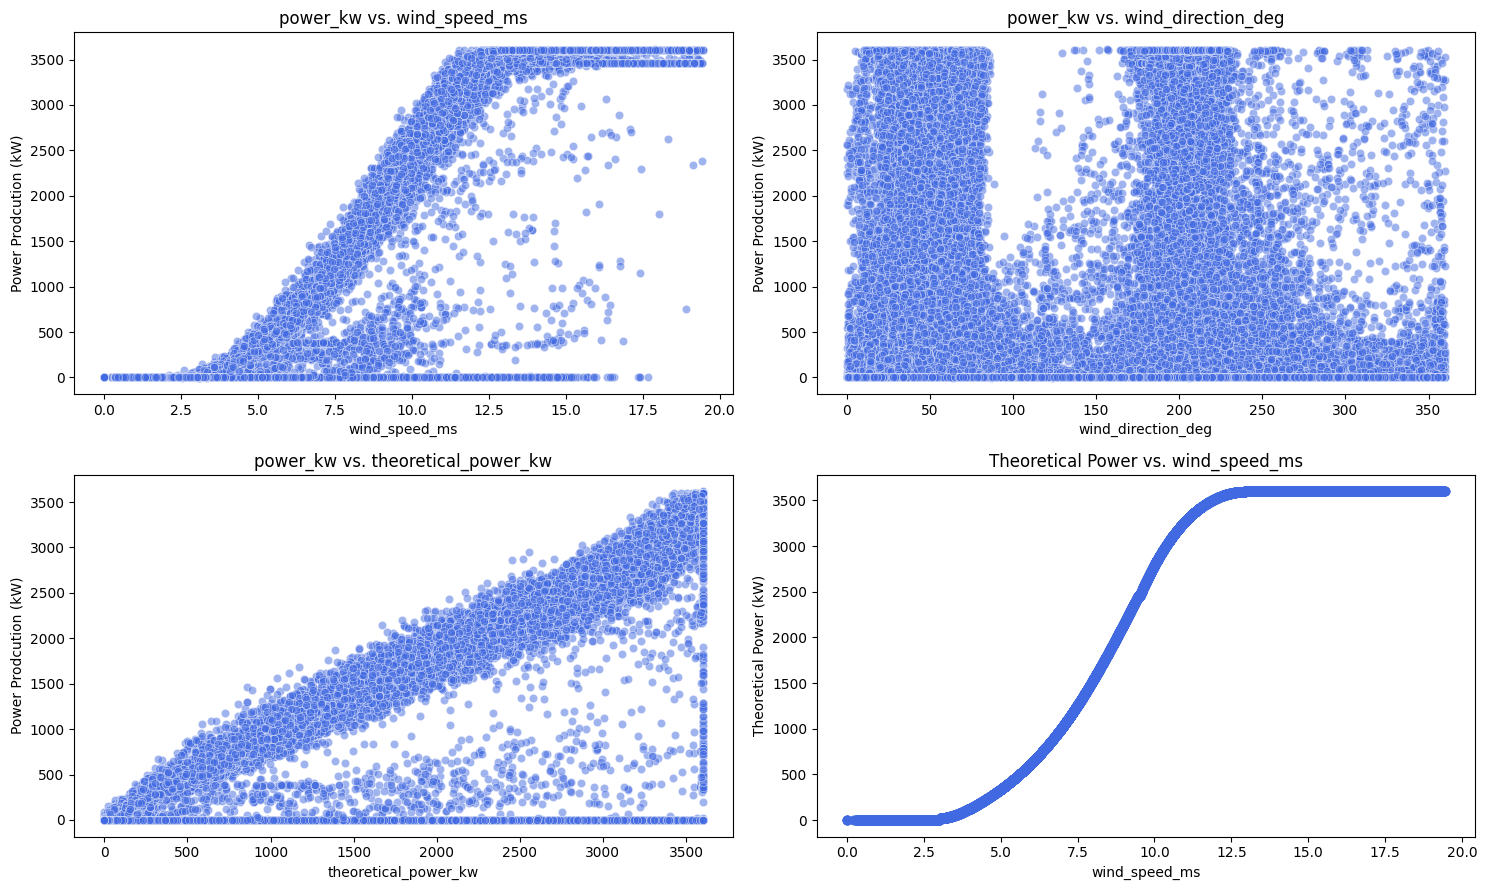

In [230]:
columns =  ['wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw',]
i=1
color = 'royalblue'
plt.figure(figsize=(15,9))
for column in columns:
    plt.subplot(2,2,i)
    sns.scatterplot(x= df[column], y= df['power_kw'], color= color, alpha=0.5, data= df)
    plt.xlabel(column)
    plt.ylabel('Power Prodcution (kW)')
    plt.title(f'power_kw vs. {column}')
    i += 1
    
plt.subplot(2,2,4)
plt.scatter(df['wind_speed_ms'], df['theoretical_power_kw'], color = color , alpha=0.5)
plt.xlabel('wind_speed_ms')
plt.ylabel('Theoretical Power (kW)')
plt.title('Theoretical Power vs. wind_speed_ms')
plt.tight_layout()
plt.show()

- Both real power production and theoretical power production is highly correlated to the wind speed.
- For real power production, even after a certain wind speed, there is still a few datapoints with a very low power.
- For wind direction, there is a certain degree of angle (between the angle of 80 to 170 and after 230) that produce very low power.

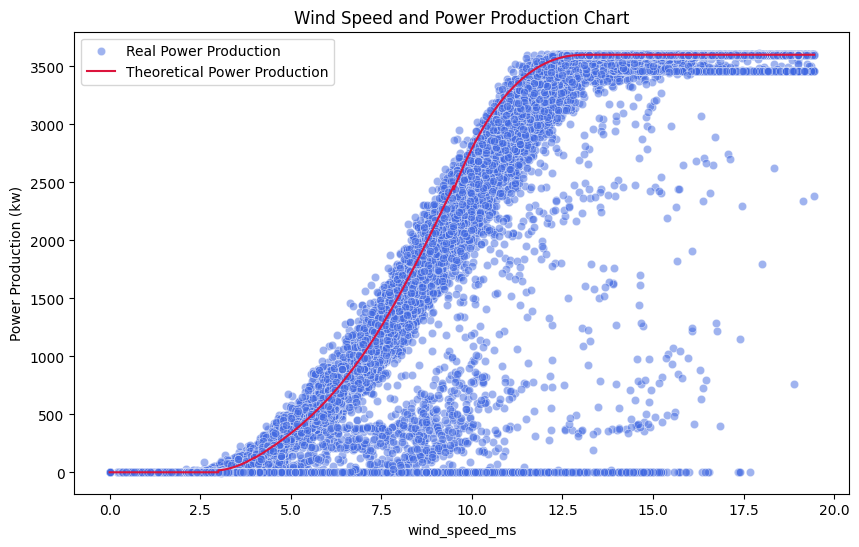

In [231]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind_speed_ms', y='power_kw', color='royalblue', label='Real Power Production', alpha=0.5, data=df)
sns.lineplot(x='wind_speed_ms', y='theoretical_power_kw', color='crimson', label='Theoretical Power Production', data=df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)')
plt.show()

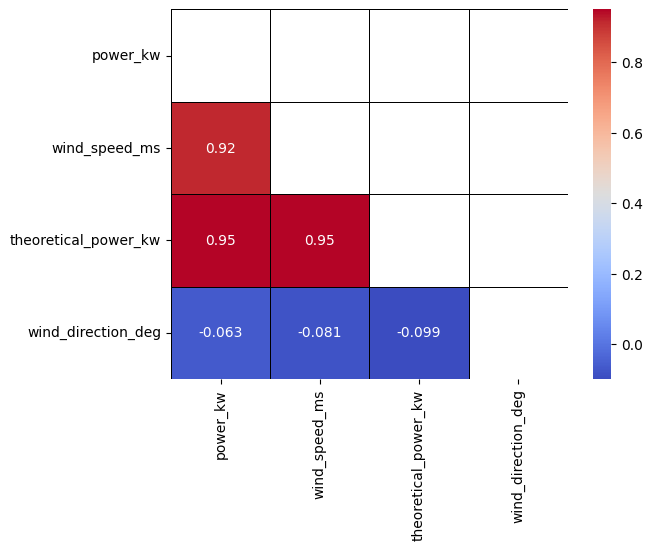

In [232]:
# Compute the correlation matrix
corr_matrix = df[['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linecolor = 'black', linewidths = .5)
plt.show()

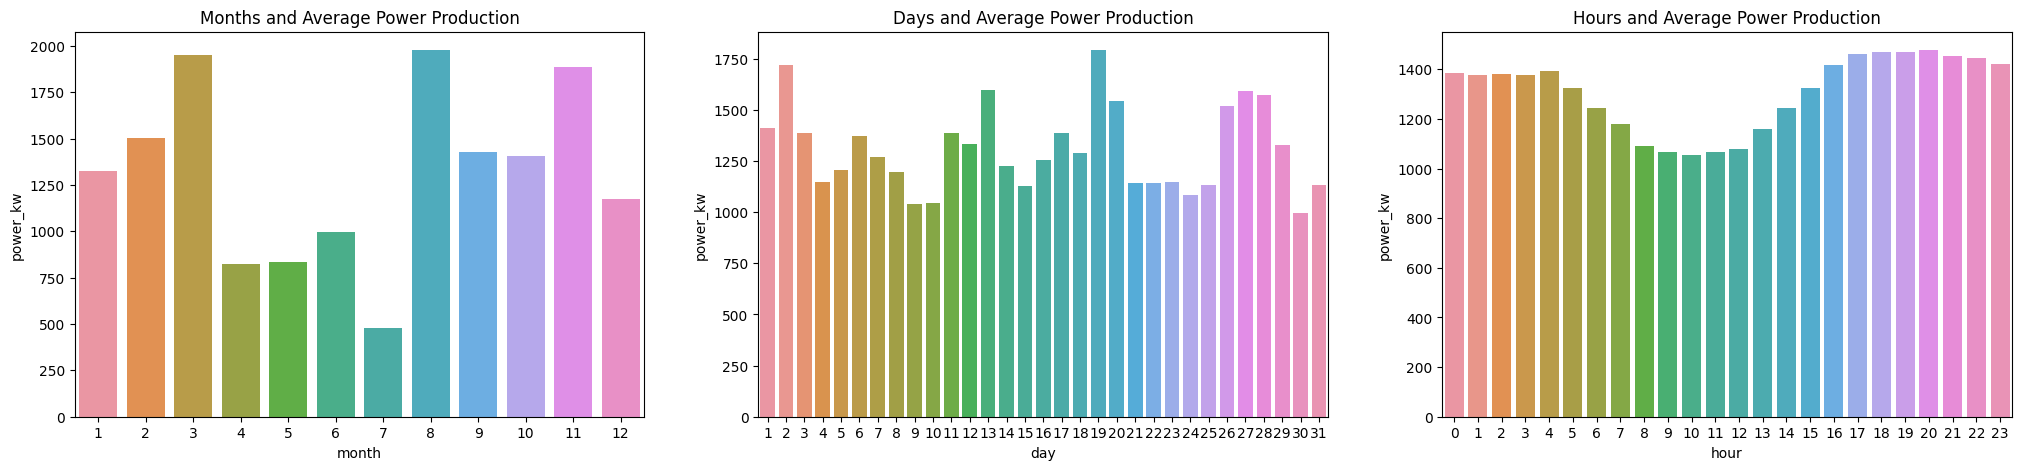

In [233]:
columns = ['month', 'day', 'hour']
i=1
plt.figure(figsize=(25,5))
for each in columns:
    avg_prod = df.groupby(each)[['power_kw']].mean().reset_index()
    plt.subplot(1,3,i)
    plt.title(f"{each.title()}s and Average Power Production")
    sns.barplot(x= each , y='power_kw', data=avg_prod)
    i += 1

# Data Prep for ML Algorithms

In [234]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor

## Defining the training features

In [235]:
# df = pd.read_csv("df.csv")
# df.head()

In [236]:
df.shape

(50530, 8)

In [237]:
features = ['power_kw', 'wind_speed_ms', 'wind_direction_deg', 'month', 'day', 'hour'] 

training_data = df[features]
X = training_data.drop(columns=['power_kw'], axis = 1).values
Y= training_data['power_kw'].values

### Train and Test data split

In [238]:
x_train , x_test , y_train , y_test = train_test_split(X, Y, test_size=0.20, random_state=1234)

print("Dimensions of train set:")
print(f"X_train: {x_train.shape}, Y_train: {y_train.shape}")
print("Dimensions of test set:")
print(f"X_test: {x_test.shape}, Y_test: {y_test.shape}")


Dimensions of train set:
X_train: (40424, 5), Y_train: (40424,)
Dimensions of test set:
X_test: (10106, 5), Y_test: (10106,)


# Model Training

In [255]:
result_scores = []
def reset_metrics():
    metrics_table.drop(index=metrics_table.index, inplace=True)
    global result_scores
    result_scores = []

In [256]:
def train_and_eval_model(models, x_train, x_test, y_train, y_test, X, model_name):
    
    """
    Trains a machine learning model and evaluates its performance using various metrics.

    Args:
        models (object): The machine learning model to be trained.
        x_train (array-like): The input training data.
        x_test (array-like): The input testing data.
        y_train (array-like): The target training data.
        y_test (array-like): The target testing data.
        X (array-like): The input data for predicting the target values.
        model_name (str): The name of the model.

    Returns:
        Tuple of y_total_prediction (array-like) for visualization, and a DataFrame of evaluation metrics.
    """
    
    global result_scores
    
    model = models
    model.fit(x_train, y_train)

    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_total_prediction = model.predict(X)

    mae = metrics.mean_absolute_error(y_test, y_pred_test)
    mse = metrics.mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_train = metrics.r2_score(y_train, y_pred_train)
    r2_test = metrics.r2_score(y_test, y_pred_test)

    result_scores.append([model_name, mae, mse, rmse, r2_train, r2_test])
    df_result_scores = pd.DataFrame(result_scores, columns=["model", "mae", "mse","rmse", "r2_train", "r2_test"])
    
    print("\t\tMetrics Table")
    print('Mean Absolute Error      : ', mae)
    print('Mean Squared  Error      : ', mse)
    print('Root Mean Squared  Error : ', rmse)
    print('R2score on Training set  : ', r2_train)
    print('R2score on Testing set   : ', r2_test)
    
    return y_total_prediction, df_result_scores




In [257]:
def visualize_power_prediction(y_predicted, y_actual, df):
    
    
    actual_power = y_actual
    predicted_power = y_predicted
    theoretical_power = df['theoretical_power_kw']
    wind_speeds = df['wind_speed_ms']
    num_samples = len(wind_speeds)
    

    plt.figure(figsize=(21, 10))
    
    # Plot actual and predicted power production vs. wind speed
    sns.scatterplot(x=wind_speeds[:num_samples], y=actual_power[:num_samples], color='blue', label='Real Power Production', marker='o')
    sns.scatterplot(x=wind_speeds[:num_samples], y=predicted_power[:num_samples], color='#3CB371', label='Predicted Power Production', alpha=0.6, marker='p')
    sns.lineplot(x='wind_speed_ms', y='theoretical_power_kw', color='crimson', label='Theoretical Power Production', data=df)
    plt.xlabel('Wind Speed (m/s)', size=12)
    plt.ylabel('Power Production (kW)', size=12)
    plt.title('Wind Turbine Power Production Prediction', size=16)
    plt.legend(fontsize=10)
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.show()


In [258]:
reset_metrics()
metrics_table

Empty DataFrame
Columns: [model, mae, mse, rmse, r2_train, r2_test]
Index: []

Decision Tree

		Metrics Table
Mean Absolute Error      :  89.89138166448878
Mean Squared  Error      :  68191.91598097188
Root Mean Squared  Error :  261.13581903096303
R2score on Training set  :  1.0
R2score on Testing set   :  0.9608392712331333


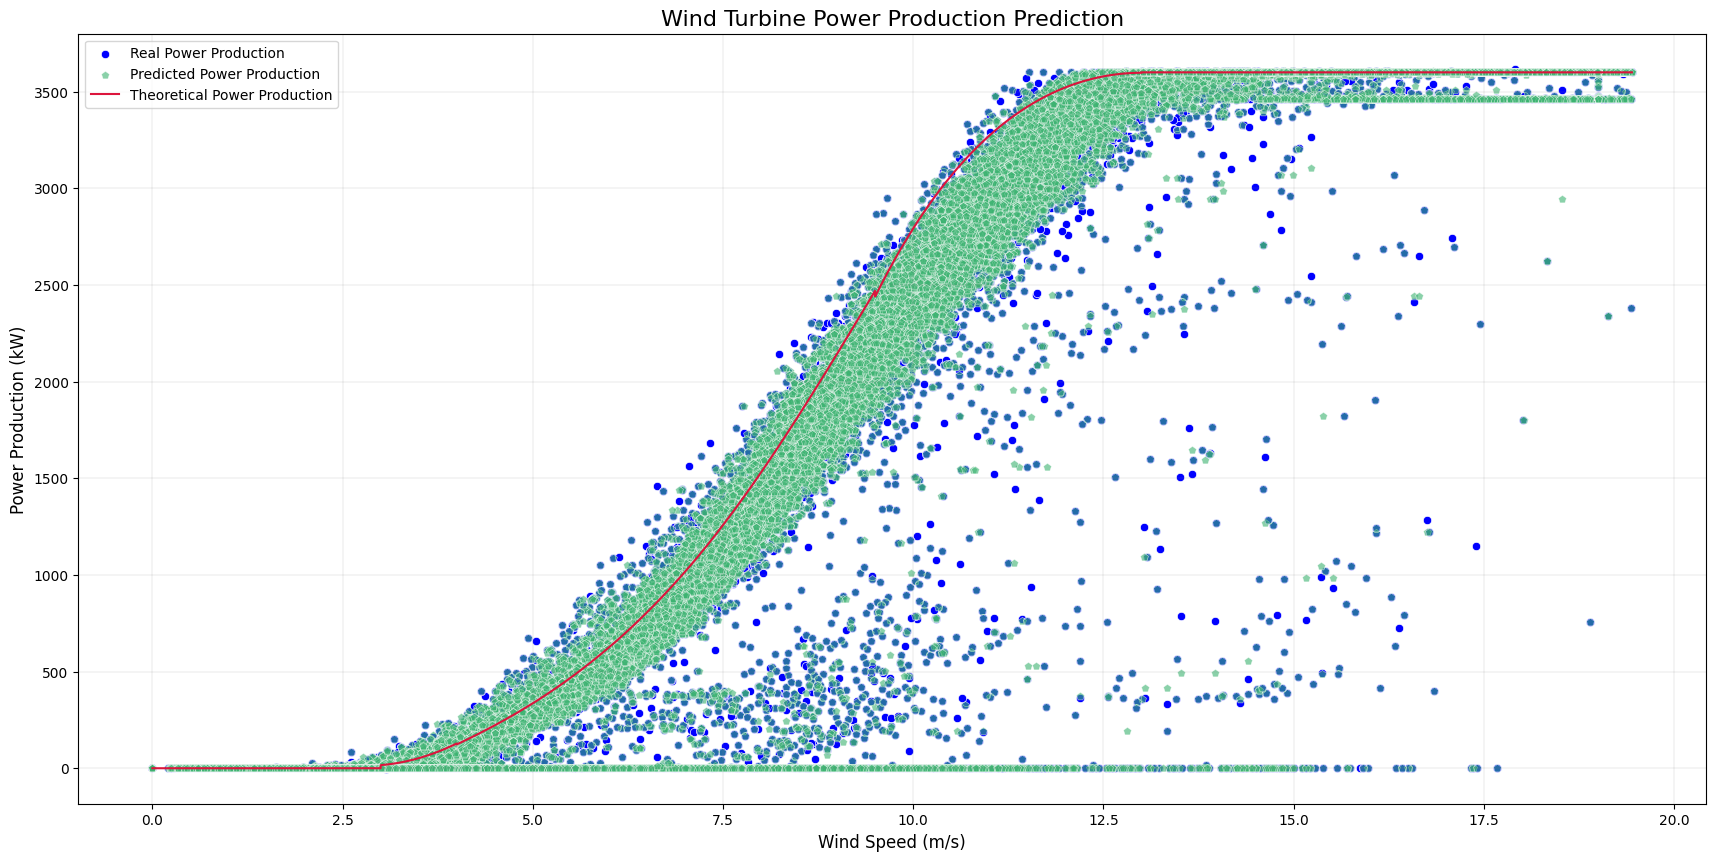

In [259]:
y_predicted, metrics_table = train_and_eval_model(DecisionTreeRegressor(), x_train, x_test, y_train, y_test, X, "decision tree")
visualize_power_prediction(y_predicted, Y, df)

XGBOOSTREG

		Metrics Table
Mean Absolute Error      :  77.26629770728479
Mean Squared  Error      :  29818.665418329463
Root Mean Squared  Error :  172.68081948592166
R2score on Training set  :  0.9905758364524266
R2score on Testing set   :  0.9828759662807688


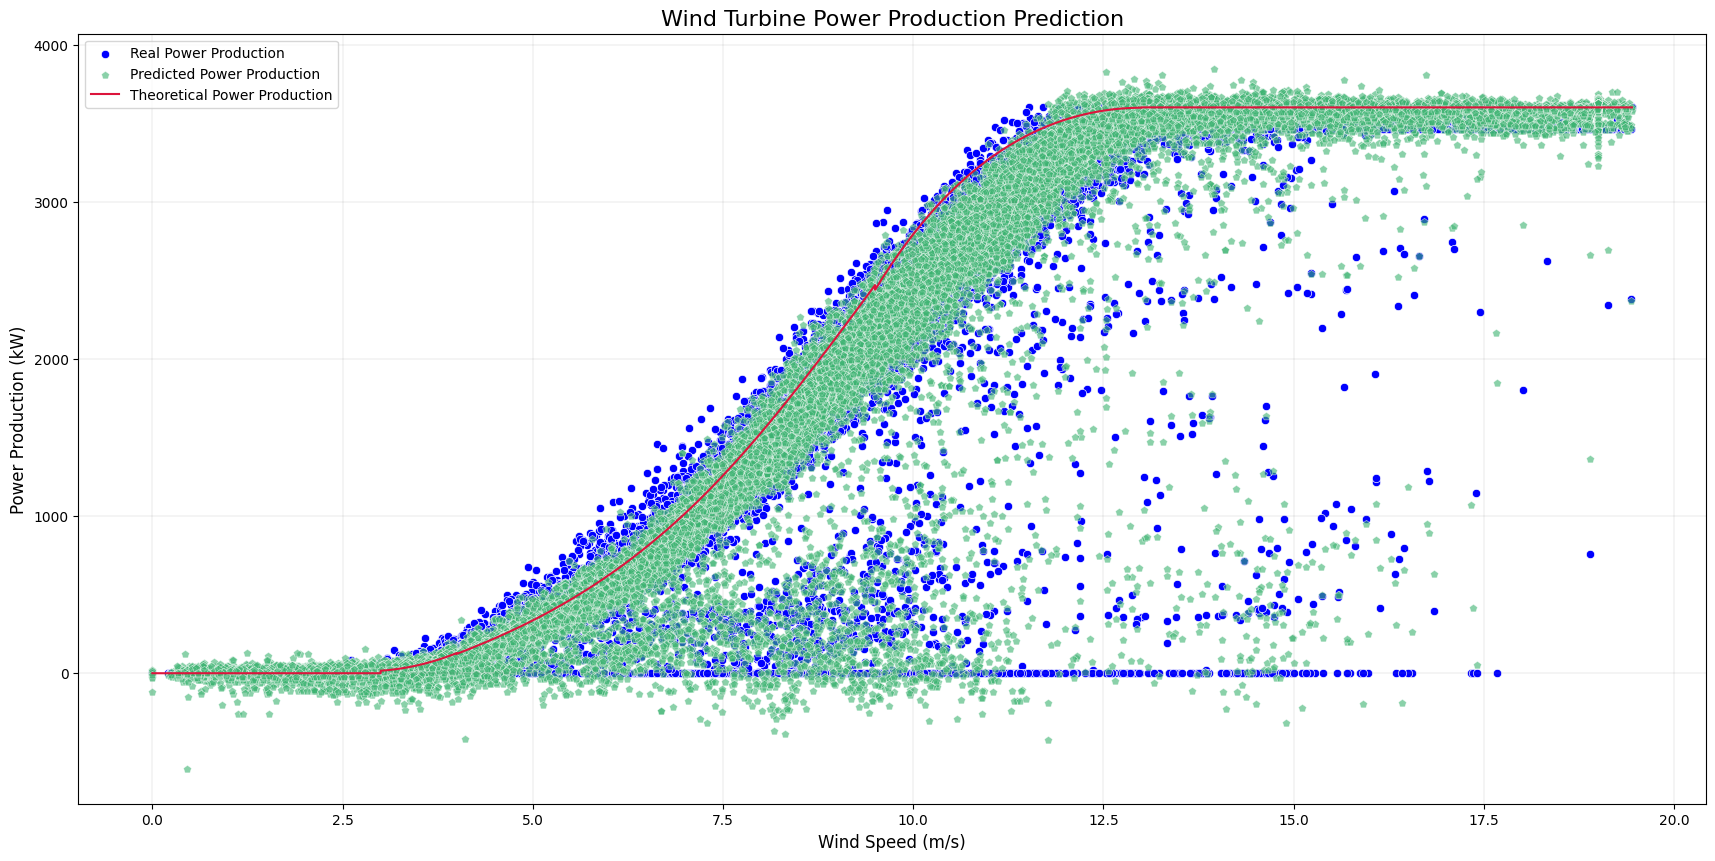

In [260]:
y_predicted, metrics_table = train_and_eval_model( XGBRegressor( ), x_train, x_test, y_train, y_test, X, "XGBREG")
visualize_power_prediction(y_predicted, Y, df)

XGB TUNED

		Metrics Table
Mean Absolute Error      :  75.92706742655983
Mean Squared  Error      :  32646.135582043404
Root Mean Squared  Error :  180.68241636098242
R2score on Training set  :  0.9908367663731062
R2score on Testing set   :  0.9812522284727784


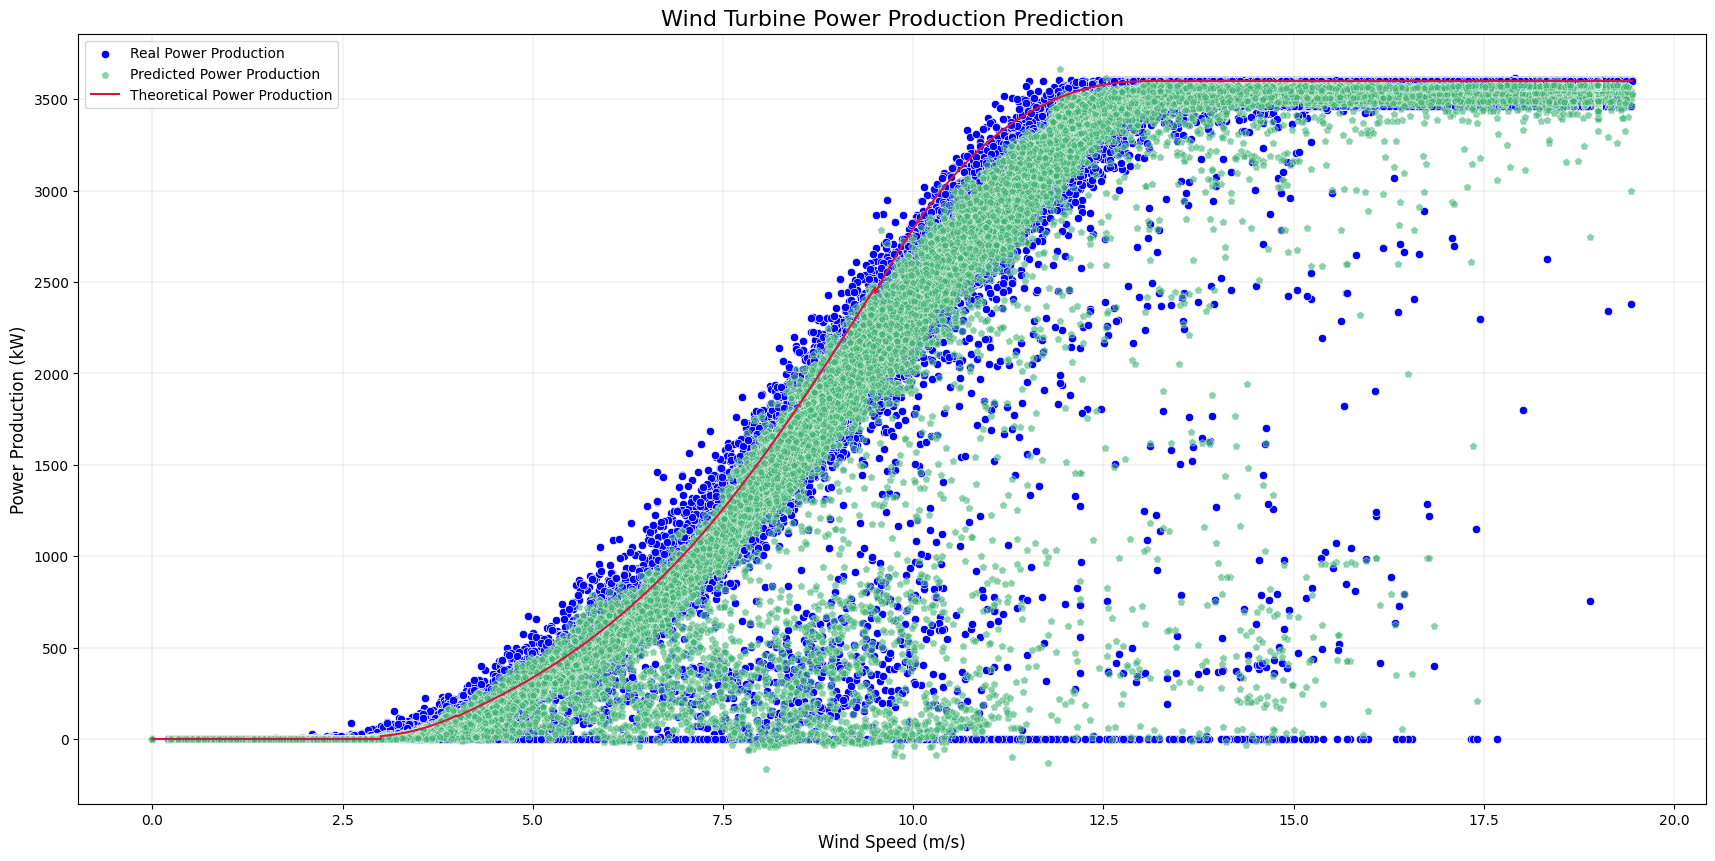

In [261]:
# without theo power
params = {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}
y_predicted, metrics_table = train_and_eval_model( XGBRegressor(**params ), x_train, x_test, y_train, y_test, X, "XGBREG_tuned")
visualize_power_prediction(y_predicted, Y, df)

Extra Tree Regressor

		Metrics Table
Mean Absolute Error      :  67.78378434595358
Mean Squared  Error      :  29748.268036760343
Root Mean Squared  Error :  172.47686232292244
R2score on Training set  :  0.999999999999999
R2score on Testing set   :  0.9829163935473423


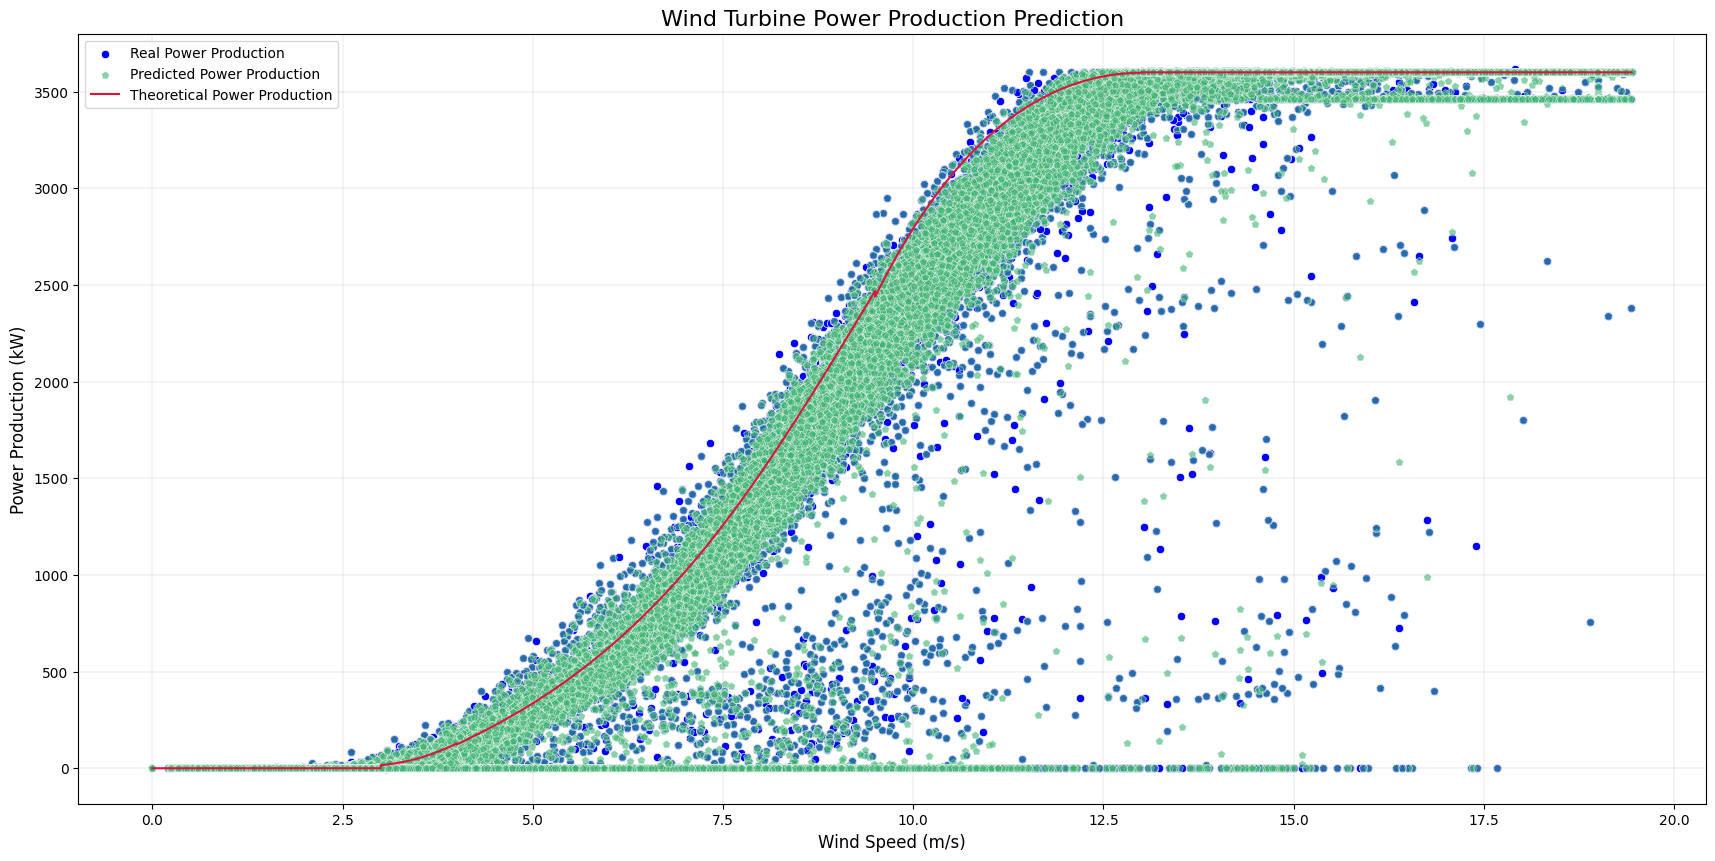

In [262]:
y_predicted, metrics_table = train_and_eval_model( ExtraTreesRegressor(), x_train, x_test, y_train, y_test, X, "Extra Tree Regressor")
visualize_power_prediction(y_predicted, Y, df)

Random Forest Regressor

		Metrics Table
Mean Absolute Error      :  72.51463818633218
Mean Squared  Error      :  34576.47589884811
Root Mean Squared  Error :  185.94750845022935
R2score on Training set  :  0.9965836722030538
R2score on Testing set   :  0.9801436874897793


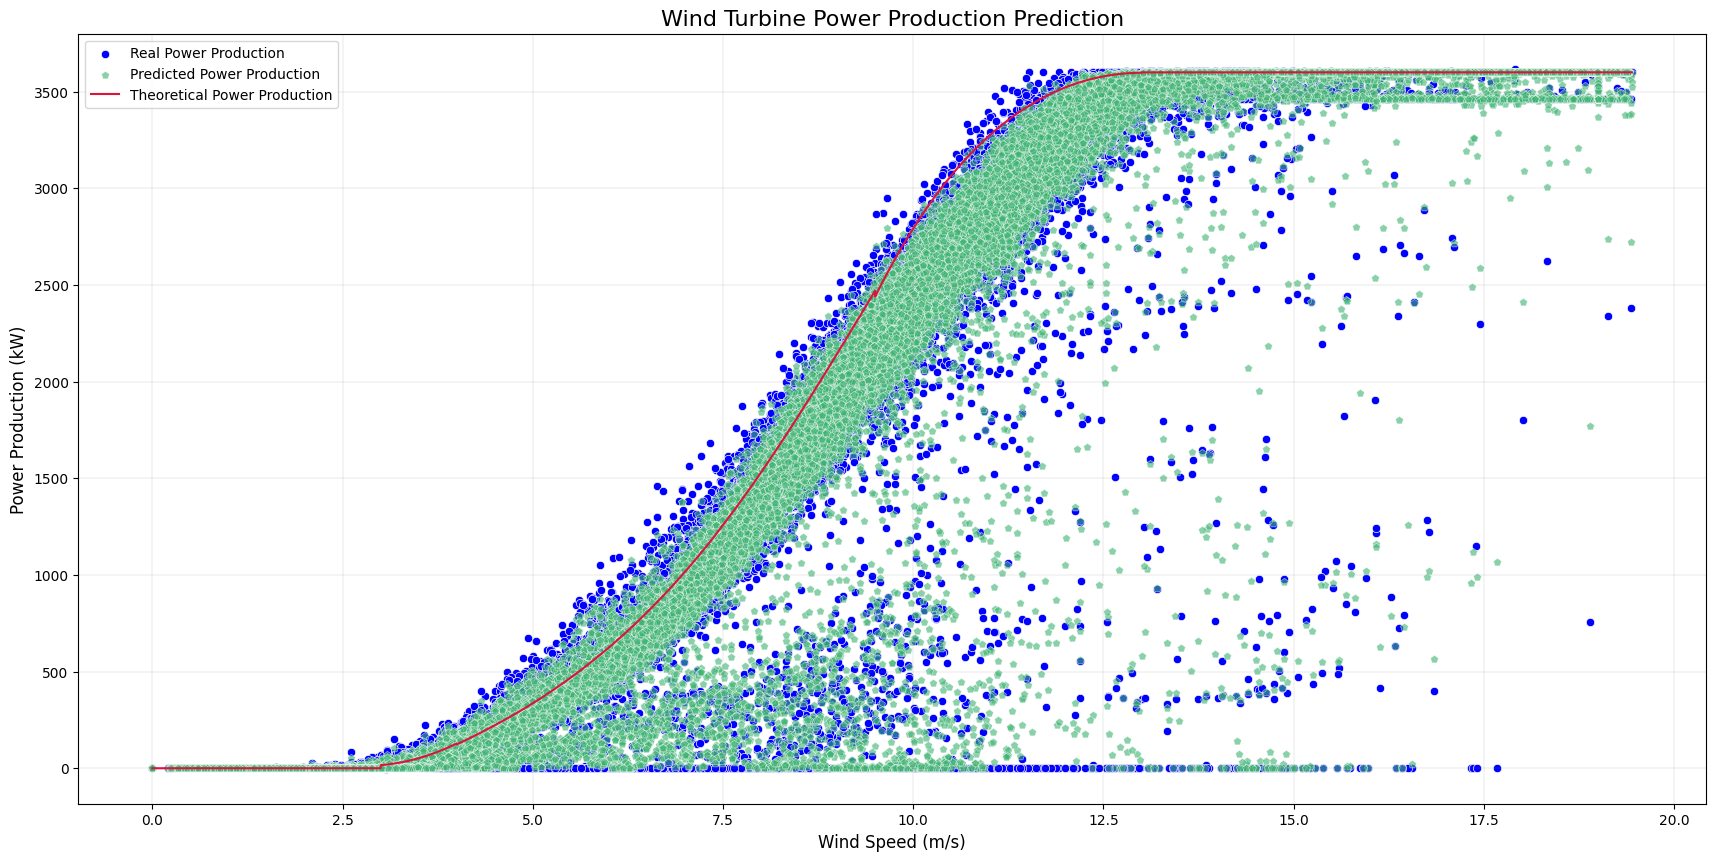

In [263]:
# baseline random forest
y_predicted, metrics_table = train_and_eval_model( RandomForestRegressor(), x_train, x_test, y_train, y_test, X, "RFR baseline")
visualize_power_prediction(y_predicted, Y, df)

Random Forest Somewhat Tuned

		Metrics Table
Mean Absolute Error      :  59.35926805956948
Mean Squared  Error      :  22477.18810832945
Root Mean Squared  Error :  149.9239410778994
R2score on Training set  :  0.9977751393312426
R2score on Testing set   :  0.9870919733770532


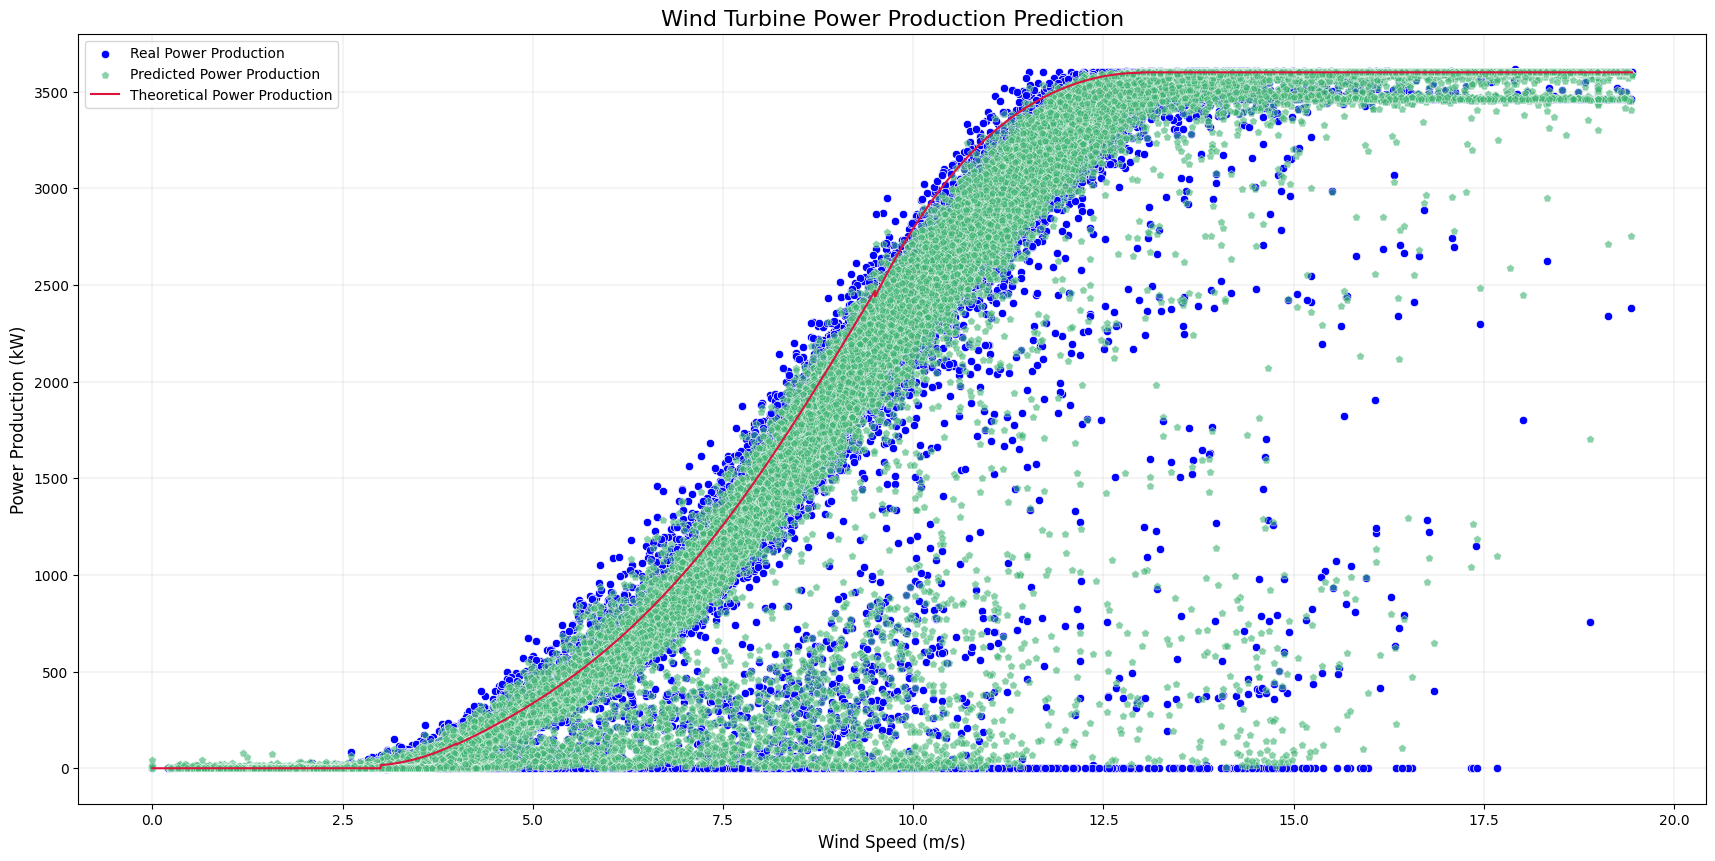

In [264]:
# without theo power
rfr_tuned = RandomForestRegressor(n_estimators=350,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=25)
y_predicted, metrics_table = train_and_eval_model( rfr_tuned, x_train, x_test, y_train, y_test, X, "RFR tuned")
visualize_power_prediction(y_predicted, Y, df)

Export Model

In [265]:
# import pickle

# # Train and get the best random forest model

# # Save the trained model to a file
# with open('best_rf.pickle', 'wb') as f:
#     pickle.dump(RFOREST, f)


In [266]:
# import bz2file as bz2
# import pickle
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor

# # Define a function to save the model using bz2file and pickle
# def compressed_pickle(title, data):
#     with bz2.BZ2File(title + '.pbz2', 'w') as f:
#         pickle.dump(data, f)

# # Save the model to a compressed pickle file
# compressed_pickle('best_rf', RFOREST)


K Neighbors Regressor

		Metrics Table
Mean Absolute Error      :  153.89825783543282
Mean Squared  Error      :  76229.19844258537
Root Mean Squared  Error :  276.09635717007455
R2score on Training set  :  0.9740508889156694
R2score on Testing set   :  0.956223682508661


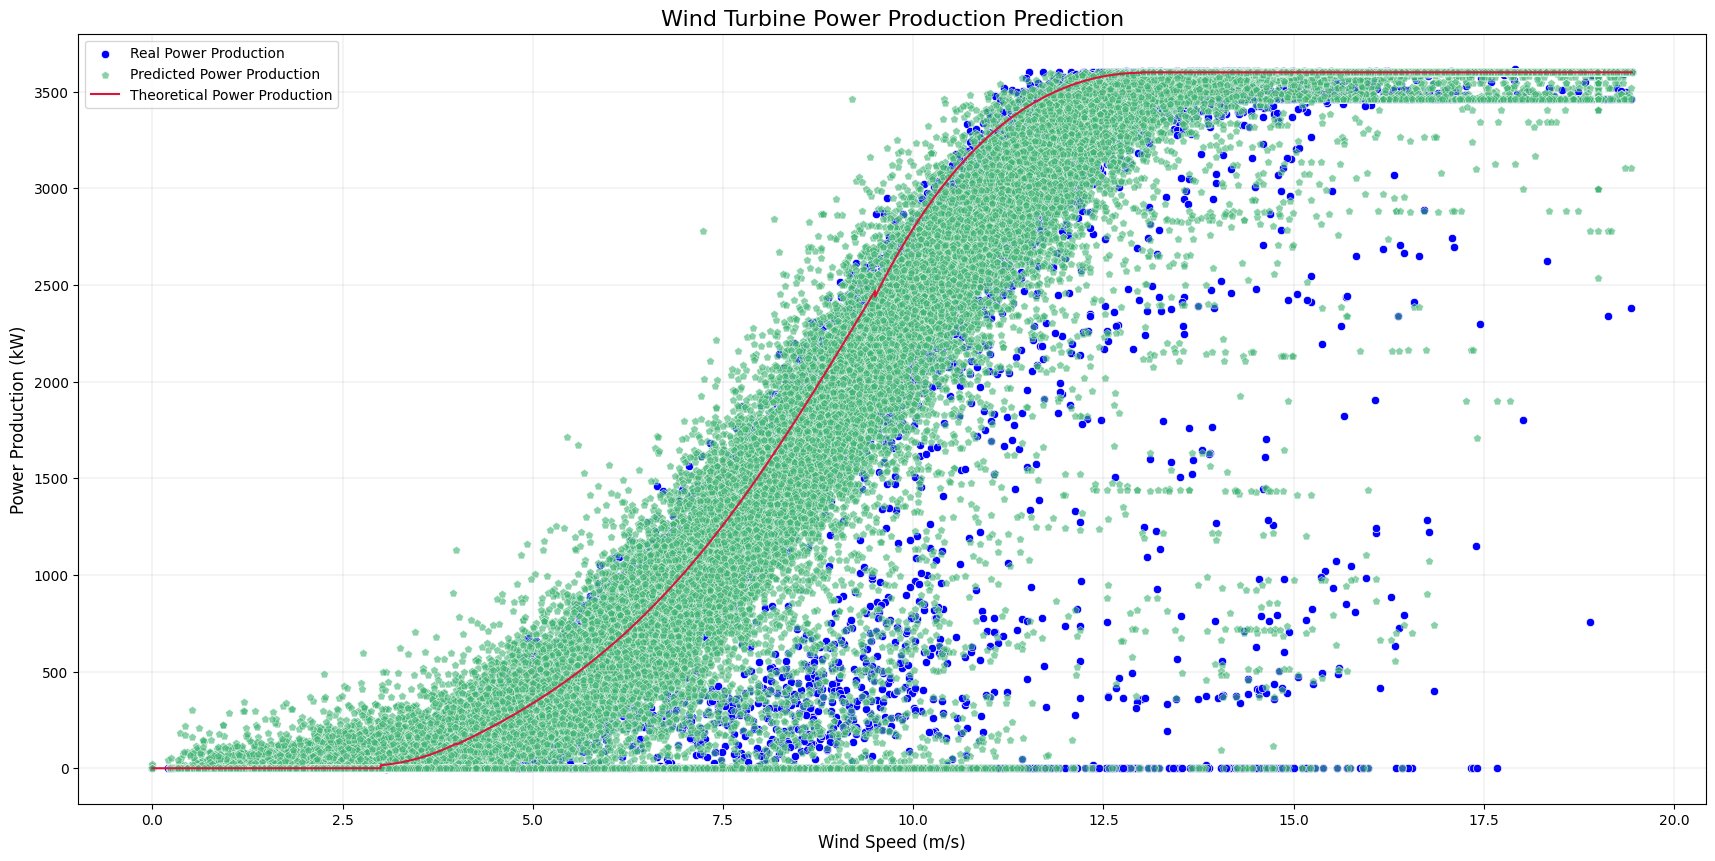

In [267]:
y_predicted, metrics_table = train_and_eval_model( KNeighborsRegressor(), x_train, x_test, y_train, y_test, X, "KKN reg")
visualize_power_prediction(y_predicted, Y, df)

# Comparing the models

In [268]:
metrics_table

model         mae           mse        rmse  r2_train   
0         decision tree   89.891382  68191.915981  261.135819  1.000000  \
1                XGBREG   77.266298  29818.665418  172.680819  0.990576   
2          XGBREG_tuned   75.927067  32646.135582  180.682416  0.990837   
3  Extra Tree Regressor   67.783784  29748.268037  172.476862  1.000000   
4          RFR baseline   72.514638  34576.475899  185.947508  0.996584   
5             RFR tuned   59.359268  22477.188108  149.923941  0.997775   
6               KKN reg  153.898258  76229.198443  276.096357  0.974051   

    r2_test  
0  0.960839  
1  0.982876  
2  0.981252  
3  0.982916  
4  0.980144  
5  0.987092  
6  0.956224